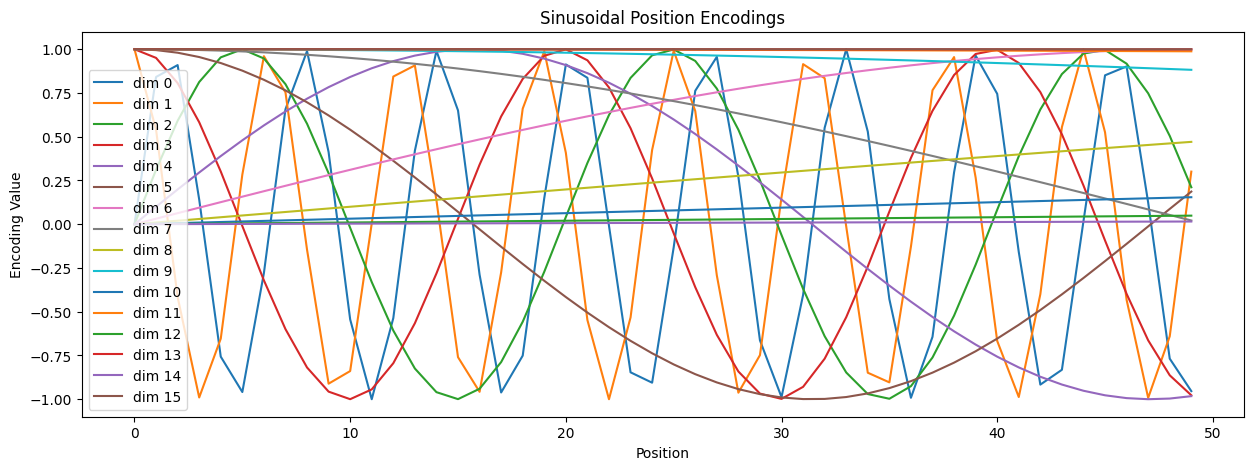

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def get_sinusoid_encoding_table(n_position, d_hid):
    """Sinusoid position encoding table"""
    def get_position_angle_vec(position):
        return [
            position / np.power(10000, 2 * (hid_j // 2) / d_hid)
            for hid_j in range(d_hid)
        ]

    sinusoid_table = np.array(
        [get_position_angle_vec(pos_i) for pos_i in range(n_position)]
    )
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

# Example: Generate position encodings
n_position = 50  # Sequence length
d_hid = 16      # Model dimension
pos_encoding_table = get_sinusoid_encoding_table(n_position, d_hid).squeeze(0).numpy()

# Plot the position encodings
plt.figure(figsize=(15, 5))
for i in range(d_hid):
    plt.plot(pos_encoding_table[:, i], label=f"dim {i}")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.title("Sinusoidal Position Encodings")
plt.legend()
plt.show()


In [3]:
pos_encoding_table.shape

(50, 16)

# **Interpolation for 2D Positional Encoding**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def cast_if_src_dtype(tensor, src_dtype, tgt_dtype):
    if tensor.dtype == src_dtype:
        return tensor.to(tgt_dtype), True
    return tensor, False

def interpolate_pos_encoding_2d(target_spatial_size, pos_embed):
    N = pos_embed.shape[1]
    if N == target_spatial_size:
        return pos_embed
    dim = pos_embed.shape[-1]
    pos_embed, updated = cast_if_src_dtype(pos_embed, torch.bfloat16, torch.float32)
    pos_embed = F.interpolate(
        pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(
            0, 3, 1, 2
        ),
        scale_factor=math.sqrt(target_spatial_size / N),
        mode="bicubic",
    )
    if updated:
        pos_embed, _ = cast_if_src_dtype(pos_embed, torch.float32, torch.bfloat16)
    pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return pos_embed


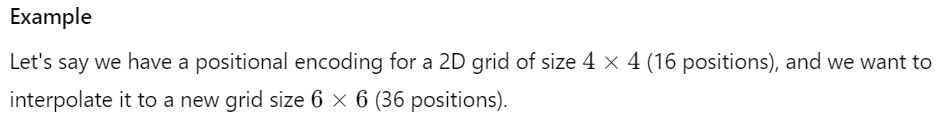

Generate Dummy Positional Encodings:
Assume the input positional encoding is for a 4x4 grid with an embedding dimension of 8.

In [7]:
import numpy as np

# Initial 4x4 positional encoding
initial_size = 4
d_model = 8
pos_embed = torch.rand(1, initial_size**2, d_model)

# New target size is 6x6
target_size = 6**2

# Interpolate
new_pos_embed = interpolate_pos_encoding_2d(target_size, pos_embed)
print(new_pos_embed.shape)


torch.Size([1, 36, 8])


Visualize the Interpolation:
Visualize the positional encodings before and after interpolation.

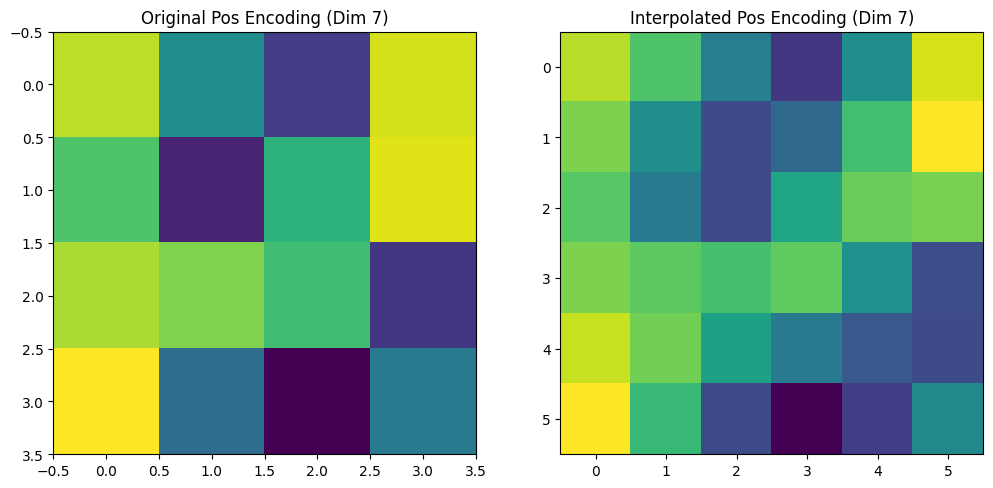

In [8]:
import matplotlib.pyplot as plt

# Original Positional Encoding (4x4)
original_pos_embed_np = pos_embed.view(initial_size, initial_size, d_model).numpy()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(d_model):
    axs[0].imshow(original_pos_embed_np[:, :, i], cmap='viridis')
    axs[0].set_title(f"Original Pos Encoding (Dim {i})")

# Interpolated Positional Encoding (6x6)
interpolated_pos_embed_np = new_pos_embed.view(6, 6, d_model).detach().numpy()
for i in range(d_model):
    axs[1].imshow(interpolated_pos_embed_np[:, :, i], cmap='viridis')
    axs[1].set_title(f"Interpolated Pos Encoding (Dim {i})")

plt.show()


# **General Interpolation for Positional Encoding**

The interpolate_pos_encoding function handles both 2D and more complex cases where the positional encoding might have a temporal component.

In [9]:
def interpolate_pos_encoding(
    npatch_per_img,
    pos_embed,
    patches_layout,
    input_shape=None,
    first_patch_idx=1,
):
    assert first_patch_idx == 0 or first_patch_idx == 1, "there is 1 CLS token or none"
    N = pos_embed.shape[1] - first_patch_idx
    if npatch_per_img == N:
        return pos_embed

    assert (
        patches_layout[-1] == patches_layout[-2]
    ), "Interpolation of pos embed not supported for non-square layouts"

    class_emb = pos_embed[:, :first_patch_idx]
    pos_embed = pos_embed[:, first_patch_idx:]

    if input_shape is None or patches_layout[0] == 1:
        pos_embed = interpolate_pos_encoding_2d(npatch_per_img, pos_embed)
    elif patches_layout[0] > 1:
        assert len(input_shape) == 4, "temporal interpolation not supported"
        num_frames = patches_layout[0]
        num_spatial_tokens = patches_layout[1] * patches_layout[2]
        pos_embed = pos_embed.view(1, num_frames, num_spatial_tokens, -1)
        pos_embed = interpolate_pos_encoding_2d(
            npatch_per_img, pos_embed[0, 0, ...].unsqueeze(0)
        )
    else:
        raise ValueError("This type of interpolation isn't implemented")

    return torch.cat((class_emb, pos_embed), dim=1)


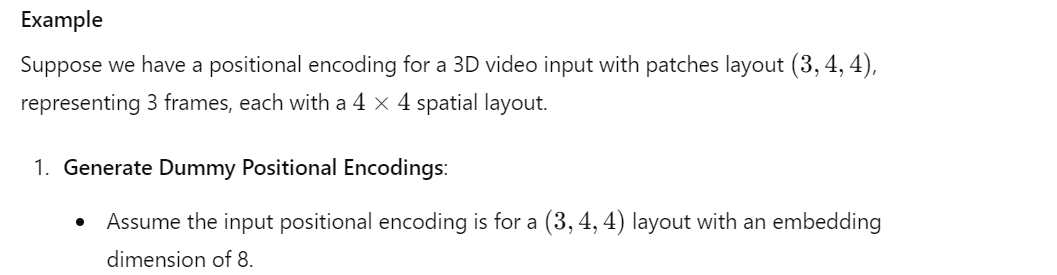

In [10]:
# Initial patches layout and positional encoding
patches_layout = [3, 4, 4]
npatch_per_img = 36
pos_embed = torch.rand(1, 49, 8)  # Including 1 CLS token

# Interpolate
new_pos_embed = interpolate_pos_encoding(
    npatch_per_img, pos_embed, patches_layout, input_shape=[1, 3, 224, 224]
)
print(new_pos_embed.shape)


torch.Size([1, 37, 8])


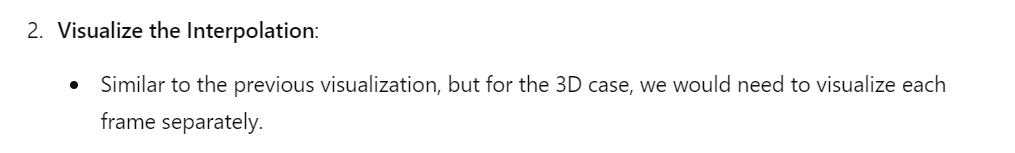

RuntimeError: shape '[1, 6, 6, 8]' is invalid for input of size 296

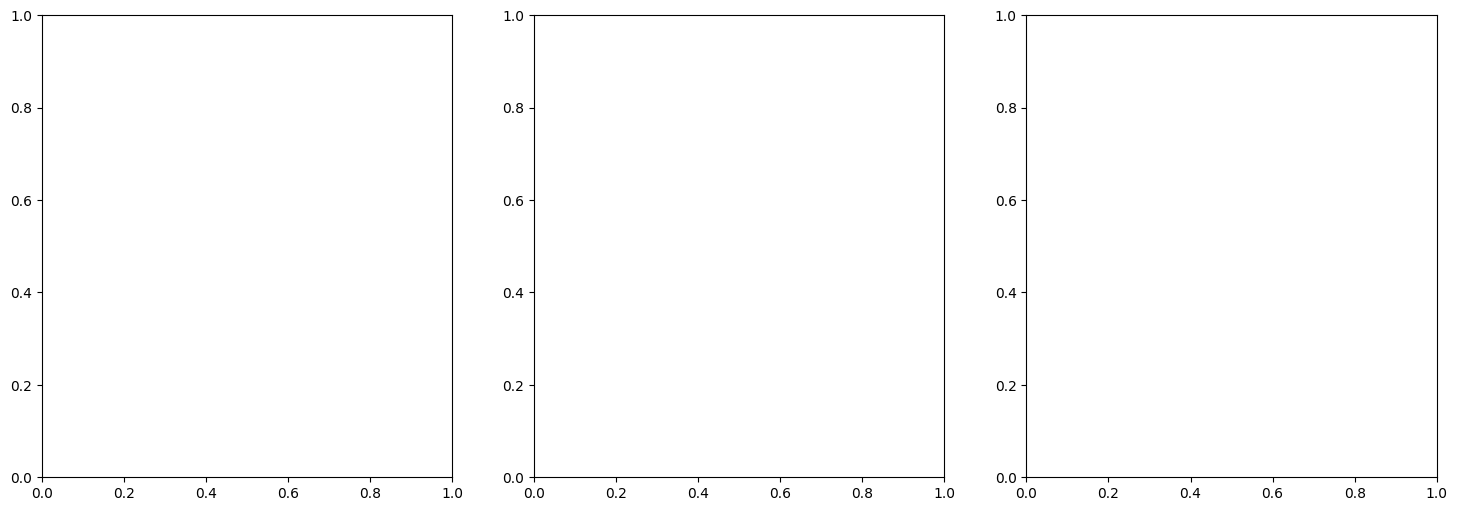

In [11]:
# Interpolated Positional Encoding Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for frame in range(patches_layout[0]):
    interpolated_pos_embed_np = new_pos_embed.view(1, 6, 6, 8).detach().numpy()
    for i in range(d_model):
        axs[frame].imshow(interpolated_pos_embed_np[frame, :, :, i], cmap='viridis')
        axs[frame].set_title(f"Interpolated Pos Encoding (Frame {frame}, Dim {i})")

plt.show()
